# Assignment 2 - DES simulation
#### Multiple Queues and Multiple Servers

For this assignment, we'll be using the following notation:
- $\lambda$ - the arrival rate into the system as a whole.
- $\mu$ - the capacity of each of $n$ equal servers.
- $\rho$ represents the system load. In a single server system, it will be: $\rho = \frac{\lambda}{\mu}$
- In a multi-server system (one queue with $n$ equal servers, each with capacity $\mu$), it will be $\rho = \frac{\lambda}{n\mu}$.

Queuing theory tells us that for FIFO scheduling, the average waiting times are shorter for an $M/M/n$ queue and a system load $\rho$ and processor capacity $\mu$ than for a single $M/M/1$ queue with the same load characteristics (and thus an $n$-fold lower arrival rate). Of course, $\rho$ must be less than one, but the experiment only becomes interesting when $\rho$ is not much less than one.

1. Look up and/or derive this theoretical result, at least for $n = 2$. Describe how it is derived. Can you also give a non-mathematical explanation?
2. Write a DES program to verify this for $n = 1, n = 2$, and $n = 4$. Make sure that your result has a high and known statistical significance. How does the number of measurements required to attain this depend on $\rho$?
3. Also compare the result to that for an $M/M/1$ queue with shortest job first scheduling, where you always give priority to the smallest jobs.
4. Now experiment with different service rate distributions. On the one hand, try the $M/D/1$ and $M/D/n$ queues; on the other hand, try a long-tail distribution. For the latter, you may, for example, use a distribution where 75% of the jobs have an exponential distribution with an average service time of 1.0, and the remaining 25% have an exponential distribution with an average service time of 5.0 (an example of a hyperexponential distribution). Write your program using SimPy.



--------
## Q1. Proof
### Little's Law
Little's Law is a theorem which states that the long-term number of customers in a queueing system, $E(L)$, relates to the average time customers spend in the system (sojourn), $E(S)$, as follows:
\begin{align*}
    E(L) = \lambda E(S)
\end{align*}
where $\lambda$ is the average arrival rate. Applying Little's Law to the queue only yields the following relation between the long-term queue length, $E(L^q)$ and the average (in-queue) waiting time, $E(W)$:
\begin{align*}
    E(L^q) = \lambda E(W)
\end{align*}

(Same for in-system: ρ = λE(B))

### Equilibruim probabilities for $M/M/n$ queue

$\Pi_W$ is the probability that a job has to wait (Delay Probability) and is given by:
\begin{align*}
    \Pi_W &= p_n + p_{n+1} + p_{n+2} + \ldots \cr
    &= \frac{p_n}{1 - \rho} \cr
    &= \frac{(n\rho)^n}{n!}[(1 - \rho) \sum_{i=0}^{n-1} \frac{(n\rho)^i}{i!} + \frac{(n\rho)^n}{n!}]^{-1} \cr
\end{align*}
where $p_n$ denotes the equilibrium probability that there are n customers in the system. See Adan 2001 for full derivation.

### Mean Queue Length $E(L^q)$ and Mean Waiting Time $E(W)$
The Mean Queue Length is defined as the long term probability that the queue has length $i$ (so probability that system has $n + i$ customers) times $i$ for all values $i$. Formally:
\begin{align*}
    E(L^q) &= \sum_{i=0}^{\infty}ip_{n+i}
\end{align*}
Combining this with the Delay Probability gives:
\begin{align*}
    E(L^q) &= \frac{p_n}{1-\rho}\sum_{i=0}^{\infty}i(1-\rho)\rho^i \cr
    &= \Pi_W \frac{\rho}{1 - \rho}
\end{align*}

From Little's Law follows: 
\begin{align*}
    E(W) &= \frac{E(L^q)}{\lambda} \cr
    &= \Pi_W \frac{1}{1 - \rho} \frac{1}{n\mu}
\end{align*}

### n = 1
In a system with a single server, we get the following:
\begin{align*}
    \Pi_W &= \frac{(1\rho)^1}{1!}[(1 - \rho) \sum_{i=0}^{1-1} \frac{(1\rho)^i}{i!} + \frac{(1\rho)^1}{1!}]^{-1} \cr
    &= \rho [ (1 - \rho) + \rho ]^{-1} \cr
    &= \rho
\end{align*}
It follows that $E(L^q_{n=1}) = \frac{\rho^2}{1 - \rho}$ and $E(W_{n=1}) = \frac{\rho}{1 - \rho}\frac{1}{\mu}$.

### n = 2
In a system with two servers, we get:
\begin{align*}
    \Pi_W &= \frac{(2\rho)^2}{2!}[(1 - \rho) \sum_{i=0}^{2-1} \frac{(2\rho)^i}{i!} + \frac{(2\rho)^2}{2!}]^{-1} \cr
    &= 2\rho [ (1 - \rho) + (1-\rho)2\rho + 2\rho^2 ]^{-1} \cr
    &= \frac{2\rho^2}{1 + \rho}
\end{align*}
It follows that $E(L^q_{n=2}) = \frac{2\rho^2}{1 + \rho}\frac{\rho}{1 - \rho} = \frac{2\rho^3}{1-\rho^2}$ and $E(W_{n=2}) = \frac{2\rho^2}{1 + \rho}\frac{1}{1 - \rho}\frac{1}{2\mu} = \frac{\rho^2}{(1-\rho^2)\mu}$.

### Comparison
We find that:
\begin{align*}
    E(W_{n=2}) &= \frac{\rho^2}{(1-\rho^2)\mu} \cr
    &= \frac{\rho}{(1-\rho)\mu} \frac{\rho}{1 + \rho} \cr
    &= E(W_{n=1}) \frac{\rho}{1 + \rho}
\end{align*}
Since $\frac{\rho}{1 + \rho} < 1 $ for $0 \leq \rho \leq 1$, it follows that:
\begin{align*}
    E(W_{n=2}) < E(W_{n=1})
\end{align*}



--------
## Q2. Explanation
Firstly, we have create the framework for a M/M/n queue in the form of a bank with counters and customers. To estimate the true average waiting time $\theta_n$ (depends on n), we proceed to run the simulation for 500 seconds and for $n \in \{1,2,4\}$, for as many repetitions as required to get the average waiting time estimate (mean) within 3 seconds of the true value with 95% confidence. With:

$$ \bar{X}_j = \frac{\sum_{i=1}^{j} X_i}{j} \text{ and } S_j^2 = \frac{\sum_{i=1}^{j} (X_i - \bar{X}_j)^2}{j-1}  $$
 
the sample mean and sample variance of j data values respectively, we keep doing additional simulations (after the first 100) and thus increasing j until the data satisfy $\frac{1.96S}{\sqrt{k}} < 3$. Satisfying this inequality means that the true mean falls within the confidence interval $[\bar{X}_j - 3, \bar{X}_j + 3 ]$ with 95% probability.


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import simpy
import itertools
import seaborn as sns
import scipy.stats as stats

from scipy.stats import norm

In [78]:
class Bank:
    """
    A bank has a limited number of counters (``NUM_COUNTERS``) to serve customers in parallel.
    """

    def __init__(self, env, num_counters, service_rate, priority="FIFO", service_type = "M"):
        """
        Initialize the bank with a number of counters (``NUM_COUNTERS``) and a service rate (``MU``).
        priority: FIFO, SJF (shortest job first).

        If shortest job first is used, we require a priorityResource
        """
        self.env = env

        if priority == "FIFO":
            self.counter = simpy.Resource(env, num_counters)
        elif priority == "SJF":
            self.counter = simpy.PriorityResource(env, num_counters)
        elif priority == "MIX50%":
            self.counter = simpy.PriorityResource(env, num_counters)
        elif priority == "MIX100%":
            self.counter = simpy.PriorityResource(env, num_counters)
        elif priority == "MIX150%":
            self.counter = simpy.PriorityResource(env, num_counters)
        elif priority == "MIX200%":
            self.counter = simpy.PriorityResource(env, num_counters)
        else:
            raise ValueError(f"Priority {priority} not supported")

        self.priority = priority
        self.service_rate = service_rate
        self.customers_served = 0
        self.waiting_times = []
        self.service_times = []
        self.service_type = service_type
    
    def serve(self, customer, waiting_time, service_time):
        """
        The customer is served for a certain amount of time.
        """
        self.customers_served += 1
        self.waiting_times.append(waiting_time)
        self.service_times.append(service_time)
        yield self.env.timeout(service_time)

def setup(env, bank, SIMULATION_TIME, arrival_rate, print_all=False):
    """
    Create new customers until the SIMULATION_TIME reaches a certain value.
    Specify the customer function to use so that different queueing disciplines can be simulated.
    """
    customer_count = itertools.count()

    # Create more cars while the simulation is running
    while env.now < SIMULATION_TIME:
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(customer(env, f'Customer {next(customer_count)}', bank, print_all=print_all))
    

def customer(env, name, bank, print_all=False):
    """
    Customer arrives, is served and leaves.
    priority: FIFO, SJF (shortest job first). 
    """
    arrive = env.now

    # Computer service time here, so it can later be used as priority
    if bank.service_type == "M":
        service_time = random.expovariate(bank.service_rate)
    elif bank.service_type == "D":
        service_time = 1.0 / bank.service_rate
    elif bank.service_type == "H":
        true_rate = bank.service_rate
        rate75 = true_rate * 2
        rate25 = true_rate / 2.5
        if random.random() < 0.75:
            service_time = random.expovariate(rate75)
        else:
            service_time = random.expovariate(rate25)
            
    if print_all:
        print(f"{env.now:.4f} {name}: Arrived (my service time is {service_time:.4f})")
        # print('%7.4f %s: Here I am' % (arrive, name))

    # Check what type of  request to make
    if bank.priority == "FIFO":
        request = bank.counter.request()
    elif bank.priority == "SJF":
        request = bank.counter.request(priority=service_time)
    elif bank.priority == "MIX50%":
        if service_time < 0.5 * 1 / MU:
            request = bank.counter.request(priority=service_time)
        else:
            request = bank.counter.request(priority=10000)
    elif bank.priority == "MIX100%":
        if service_time < 1.0 * 1 / MU:
            request = bank.counter.request(priority=service_time)
        else:
            request = bank.counter.request(priority=10000)
    elif bank.priority == "MIX150%":
        if service_time < 1.5 * 1 / MU:
            request = bank.counter.request(priority=service_time)
        else:
            request = bank.counter.request(priority=10000)
    elif bank.priority == "MIX200%":
        if service_time < 2.0 * 1 / MU:
            request = bank.counter.request(priority=service_time)
        else:
            request = bank.counter.request(priority=10000)
    with request as req:
        yield req
        wait = env.now - arrive

        if print_all:
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))

        yield env.process(bank.serve(name, wait, service_time))

        if print_all:
            print('%7.4f %s: Finished' % (env.now, name))

# Example usage:
RANDOM_SEED = 42
LAMBDA = 1/12 # Arrival rate
MU = 1/10 # Service rate
SIMULATION_TIME = 50
n = 1 # Number of counters

LOAD = LAMBDA/(MU * n) # Load of the system, should be < 1 for stable system

print(f"M/M/1 queue simulation with λ={LAMBDA}, μ={MU}, ρ = {LOAD}")
print(f"Simulation time: {SIMULATION_TIME}")

random.seed(RANDOM_SEED)
env = simpy.Environment()

bank = Bank(env, n, MU)

env.process(setup(env, bank, SIMULATION_TIME, LAMBDA, print_all=True))
env.run()

print(f"Customers served: {bank.customers_served}")
print(f"Average waiting time: {sum(bank.waiting_times)/len(bank.waiting_times)}")


M/M/1 queue simulation with λ=0.08333333333333333, μ=0.1, ρ = 0.8333333333333333
Simulation time: 50
12.2407 Customer 0: Arrived (my service time is 3.2162)
12.2407 Customer 0: Waited  0.000
12.5447 Customer 1: Arrived (my service time is 13.3359)
15.4570 Customer 0: Finished
15.4570 Customer 1: Waited  2.912
15.5757 Customer 2: Arrived (my service time is 22.2729)
28.7929 Customer 1: Finished
28.7929 Customer 2: Waited 13.217
29.1258 Customer 3: Arrived (my service time is 5.4805)
30.2172 Customer 4: Arrived (my service time is 2.4672)
30.5802 Customer 5: Arrived (my service time is 0.2689)
39.0272 Customer 6: Arrived (my service time is 10.4949)
41.6875 Customer 7: Arrived (my service time is 2.4903)
51.0658 Customer 2: Finished
51.0658 Customer 3: Waited 21.940
51.1354 Customer 8: Arrived (my service time is 8.8981)
56.5462 Customer 3: Finished
56.5462 Customer 4: Waited 26.329
59.0134 Customer 4: Finished
59.0134 Customer 5: Waited 28.433
59.2823 Customer 5: Finished
59.2823 Custom

In [79]:
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 1/10 # Service rate
LOAD = 0.99 # Load factor

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 3
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

for n in [1, 2, 4]:
    avg_customers_served = []
    avg_waiting_times = []
    avg_service_times = []

    while True:
        LAMBDA = MU * LOAD * n

        env = simpy.Environment()
        bank = Bank(env, n, MU)

        env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
        env.run()

        avg_customers_served.append(bank.customers_served)
        avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))
        avg_service_times.append(sum(bank.service_times)/len(bank.service_times))

        # Only start checking after 100 repetitions
        if len(avg_waiting_times) < 100:
            continue

        # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
        S = np.std(avg_waiting_times, ddof=1)

        if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
            break

    # Print results
    print(f"M/M/{n} queue simulation with λ = {round(LAMBDA, decimals)}, μ = {round(MU, decimals)}, ρ = {round(LOAD, decimals)} ({len(avg_waiting_times)} repetitions to reach 95% confidence)")
    print(f"Customers served: {round(np.mean(avg_customers_served), decimals)}")
    print(f"Average waiting time: {round(np.mean(avg_waiting_times), decimals)} s")
    # print(f"Average service time: {round(np.mean(avg_service_times), decimals)} s\n")

M/M/1 queue simulation with λ = 0.099, μ = 0.1, ρ = 0.99 (506 repetitions to reach 95% confidence)
Customers served: 50.3893
Average waiting time: 44.8067 s
M/M/2 queue simulation with λ = 0.198, μ = 0.1, ρ = 0.99 (214 repetitions to reach 95% confidence)
Customers served: 99.1542
Average waiting time: 29.5166 s
M/M/4 queue simulation with λ = 0.396, μ = 0.1, ρ = 0.99 (100 repetitions to reach 95% confidence)
Customers served: 199.43
Average waiting time: 21.2155 s


### Plotting the box plot when server number = [1,2,4]

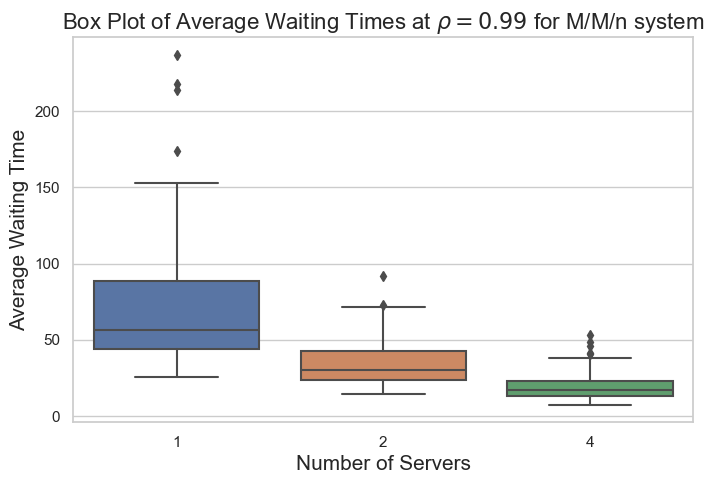

In [80]:
def run_simulation(num_servers):
    avg_waiting_times = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        bank = Bank(env, num_servers, MU)
        env.process(setup(env, bank, SIMULATION_TIME, num_servers * MU * 0.9))
        env.run()
        avg_waiting_times.append(np.mean(bank.waiting_times))
    return avg_waiting_times

# Parameters for the simulation
MU = 1/10 # Service rate
SIMULATION_TIME = 5000
SIMULATIONS = 100
servers = [1, 2, 4]

# Dictionary to hold simulation results
simulation_results = {}

# Run simulations for different numbers of servers
for num_servers in servers:
    simulation_results[num_servers] = run_simulation(num_servers)

# Preparing data for box plot
data_for_plot = []
for num_servers, times in simulation_results.items():
    for time in times:
        data_for_plot.append([num_servers, time])

# Convert data to DataFrame for plotting
df = pd.DataFrame(data_for_plot, columns=['Servers', 'Mean Waiting Time'])

# Generate box plot
plt.figure(figsize=(8, 5))
sns.set(style='whitegrid')
sns.boxplot(x='Servers', y='Mean Waiting Time', data=df)
plt.title(r'Box Plot of Average Waiting Times at $\rho=0.99$ for M/M/n system', fontsize=16)
plt.xlabel('Number of Servers', fontsize = 15)
plt.ylabel('Average Waiting Time', fontsize = 15)
plt.savefig("2.1 box plot.jpg", dpi=300)
plt.show()

### Normal Distribution Test

In [81]:
def shapiro_wilk_normality_test(data, significance_level=0.05):
    """Perform Shapiro-Wilk normality test on the given data at 95% confidence level."""
    result = stats.shapiro(data)
    print("Shapiro-Wilk test results:")
    print(f"Statistic: {result.statistic}")
    print(f"p-value: {result.pvalue}")
    if result.pvalue > significance_level:
        print("Data appears to be normally distributed at 95% confidence level.")
    else:
        print("Data does not appear to be normally distributed at 95% confidence level.")

for num_servers, times in simulation_results.items():
    print(f"Number of servers: {num_servers}")
    shapiro_wilk_normality_test(times)

Number of servers: 1
Shapiro-Wilk test results:
Statistic: 0.8109981417655945
p-value: 5.46685807734093e-10
Data does not appear to be normally distributed at 95% confidence level.
Number of servers: 2
Shapiro-Wilk test results:
Statistic: 0.9135512113571167
p-value: 6.505357760033803e-06
Data does not appear to be normally distributed at 95% confidence level.
Number of servers: 4
Shapiro-Wilk test results:
Statistic: 0.8808999061584473
p-value: 1.9815853136151418e-07
Data does not appear to be normally distributed at 95% confidence level.


In [82]:
# Function to calculate expected frequencies for a normal distribution
def calculate_expected_frequencies(observed_data):
    mean = np.mean(observed_data)
    std = np.std(observed_data)
    # Determine the bin edges for the histogram
    bin_edges = np.histogram_bin_edges(observed_data, bins='auto')
    # Calculate the expected frequencies for each bin
    expected_freqs = stats.norm(loc=mean, scale=std).cdf(bin_edges[1:]) - stats.norm(loc=mean, scale=std).cdf(bin_edges[:-1])
    # Scale the expected frequencies to match the total number of observations
    expected_freqs *= len(observed_data)
    return expected_freqs, bin_edges

# Running chi-square tests for each server count using the simulation results
chi_square_results = {}
for num_servers, times in simulation_results.items():
    # Calculate the observed frequencies using numpy's histogram function
    observed_freq, _ = np.histogram(times, bins='auto')
    # Calculate the expected frequencies for a normal distribution
    expected_freq, bin_edges = calculate_expected_frequencies(times)
    # Scale expected frequencies to match the observed data
    expected_freq = expected_freq / expected_freq.sum() * observed_freq.sum()
    # Perform the chi-square test
    chi_stat, p_val = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq)
    chi_square_results[num_servers] = (chi_stat, p_val)

# Output the chi-square test results
for servers, (chi_stat, p_val) in chi_square_results.items():
    print(f"Number of servers: {servers}")
    print(f"Chi-square Statistic: {chi_stat}, p-value: {p_val}")

Number of servers: 1
Chi-square Statistic: 299.4849999455127, p-value: 1.9975876667674993e-58
Number of servers: 2
Chi-square Statistic: 47.226770132146, p-value: 3.5607952108911216e-07
Number of servers: 4
Chi-square Statistic: 41.38317868369136, p-value: 9.650894717577381e-06


In [83]:
# Define a function to perform the Kolmogorov-Smirnov tes
def perform_ks_test(simulation_results):
    ks_results = {}
    for num_servers, times in simulation_results.items():
        # The KS test is comparing the sample against a normal distribution with the same mean and std dev as the sample
        D, p_value = stats.kstest(times, 'norm', args=(np.mean(times), np.std(times)))
        ks_results[num_servers] = (D, p_value)
    return ks_results

# Perform the Kolmogorov-Smirnov test
ks_test_results = perform_ks_test(simulation_results)

# Display the results
for server_count, (D, p_value) in ks_test_results.items():
    print(f"Number of servers: {server_count}")
    print(f"KS Statistic: {D}, p-value: {p_value}")



Number of servers: 1
KS Statistic: 0.15194930142559082, p-value: 0.017596001269123307
Number of servers: 2
KS Statistic: 0.11871221247527997, p-value: 0.1099750579205302
Number of servers: 4
KS Statistic: 0.14310085926469462, p-value: 0.029957686035630093


### For different $\rho$:

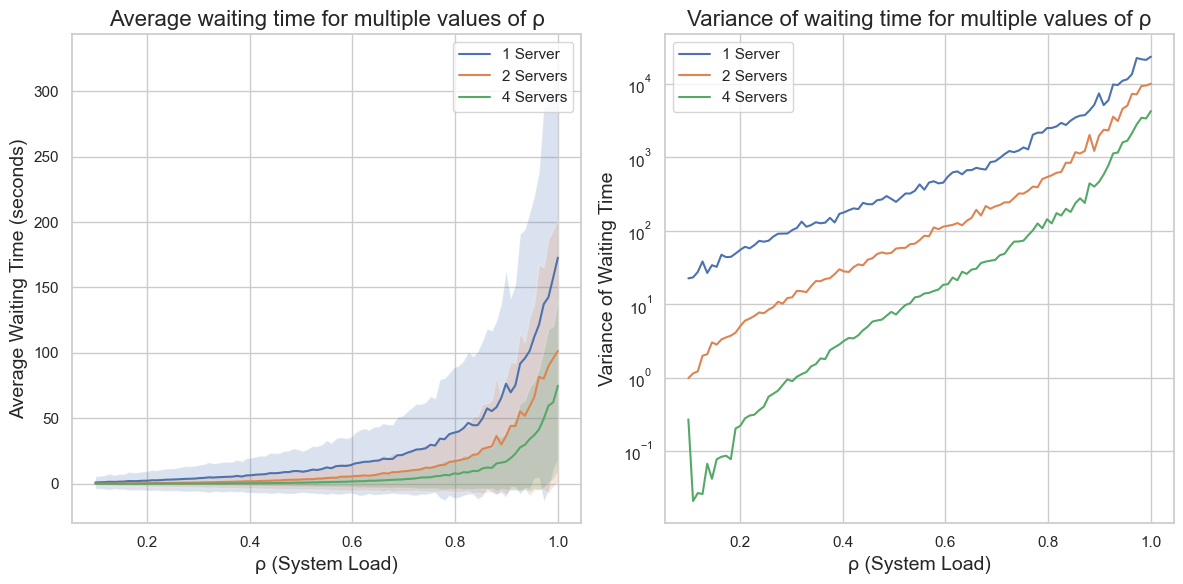

In [84]:
# Run simulation for different number of servers and system load (rho)
def run_simulation_for_rho(num_counters_list, rho_values, SIMULATION_TIME, service_rate):
    results = {}
    for num_counters in num_counters_list:
        results[num_counters] = {'rho': [], 'avg_waiting_times': [], 'variance_waiting_times': []}
        for rho in rho_values:
            # Lists to accumulate waiting times for each rho value
            waiting_times_accumulator = []
            for _ in range(SIMULATIONS):
                env = simpy.Environment()
                bank = Bank(env, num_counters, service_rate)
                env.process(setup(env, bank, SIMULATION_TIME, rho * service_rate * num_counters))
                env.run()
                waiting_times_accumulator.extend(bank.waiting_times)
            # Calculate average and variance over all simulations for the current rho
            results[num_counters]['rho'].append(rho)
            results[num_counters]['avg_waiting_times'].append(np.mean(waiting_times_accumulator))
            results[num_counters]['variance_waiting_times'].append(np.var(waiting_times_accumulator))
    return results

# Parameters for the simulations
MU = 1/10  # fixed service rate
NUM_COUNTERS_LIST = [1, 2, 4]  # different numbers of servers
SIMULATION_TIME = 5000  # extended simulation time for more data
RHO_VALUES = np.linspace(0.1, 1, 99)  # range of system loads to explore

# Run the simulations
simulation_results = run_simulation_for_rho(NUM_COUNTERS_LIST, RHO_VALUES, SIMULATION_TIME, MU)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot Average Waiting Time with shaded area for each simulation run
plt.subplot(1, 2, 1)
for num_counters in NUM_COUNTERS_LIST:
    avg_wait = simulation_results[num_counters]['avg_waiting_times']
    plt.plot(RHO_VALUES, avg_wait, label=f'{num_counters} Server{"s" if num_counters > 1 else ""}')
    # Plot the shaded area with variance
    variance_wait = simulation_results[num_counters]['variance_waiting_times']
    plt.fill_between(RHO_VALUES, avg_wait - np.sqrt(variance_wait), avg_wait + np.sqrt(variance_wait), alpha=0.2)

plt.title('Average waiting time for multiple values of ρ', fontsize=16)
plt.xlabel('ρ (System Load)', fontsize=14)
plt.ylabel('Average Waiting Time (seconds)', fontsize=14)
plt.legend()

# Plot Variance as a line plot without shaded area
plt.subplot(1, 2, 2)
for num_counters in NUM_COUNTERS_LIST:
    variance_wait = simulation_results[num_counters]['variance_waiting_times']
    plt.plot(RHO_VALUES, variance_wait, label=f'{num_counters} Server{"s" if num_counters > 1 else ""}')

plt.title('Variance of waiting time for multiple values of ρ', fontsize=16)
plt.xlabel('ρ (System Load)', fontsize=14)
plt.ylabel('Variance of Waiting Time', fontsize=14)
plt.yscale('log')  # Log scale for better visibility
plt.legend()

plt.tight_layout()
plt.savefig("2.2 mean and variance.jpg", dpi=300)
plt.show()


#### Confidence interval analysis using CLT

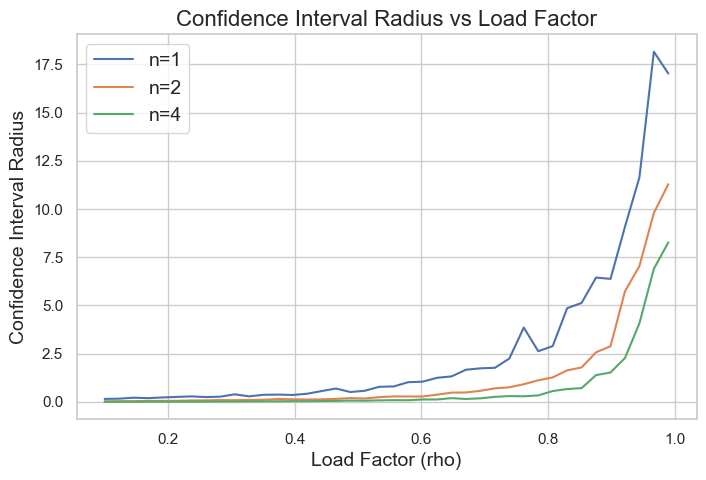

In [85]:
def simulate_bank(env, num_counters, service_rate, arrival_rate, simulation_time):
    bank = Bank(env, num_counters, service_rate)
    env.process(setup(env, bank, simulation_time, arrival_rate))
    env.run()
    return np.mean(bank.waiting_times)

def calculate_ci(average_times, confidence=0.95):
    n = len(average_times)
    mean = np.mean(average_times)
    sem = np.std(average_times, ddof=1) / np.sqrt(n)
    margin = sem * norm.ppf((1 + confidence) / 2)
    return mean, margin

# Set simulation parameters
RANDOM_SEED = 42
MU = 1/10  # Service rate
SIMULATION_TIME = 5000  # Total time for each simulation
NUM_SIMULATIONS = 100  # Number of simulations per load factor
CONFIDENCE = 0.95  # Confidence level for CI
n_values = [1, 2, 4]  # Different numbers of servers to simulate
rho_values = np.linspace(0.1, 0.99, 40)  # Load factors

# Set the random seed for reproducibility
random.seed(RANDOM_SEED)

# Store the results
ci_results = []

# Run the simulations
for n in n_values:
    for rho in rho_values:
        arrival_rate = MU * n * rho
        average_times = []
        for _ in range(NUM_SIMULATIONS):
            env = simpy.Environment()
            avg_time = simulate_bank(env, n, MU, arrival_rate, SIMULATION_TIME)
            average_times.append(avg_time)
        mean, margin = calculate_ci(average_times, CONFIDENCE)
        ci_results.append((n, rho, mean, margin))

# Plotting the results
plt.figure(figsize=(8, 5))

for n in n_values:
    n_results = [(rho, margin) for n_res, rho, mean, margin in ci_results if n_res == n]
    rho_values, margins = zip(*n_results)
    plt.plot(rho_values, margins, label=f'n={n}')

plt.xlabel('Load Factor (rho)', fontsize=14)
plt.ylabel('Confidence Interval Radius', fontsize=14)
plt.title('Confidence Interval Radius vs Load Factor', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("2.3 CI.jpg", dpi=300)
plt.show()


#### How many simulations do we need to get CI_radius down to 3

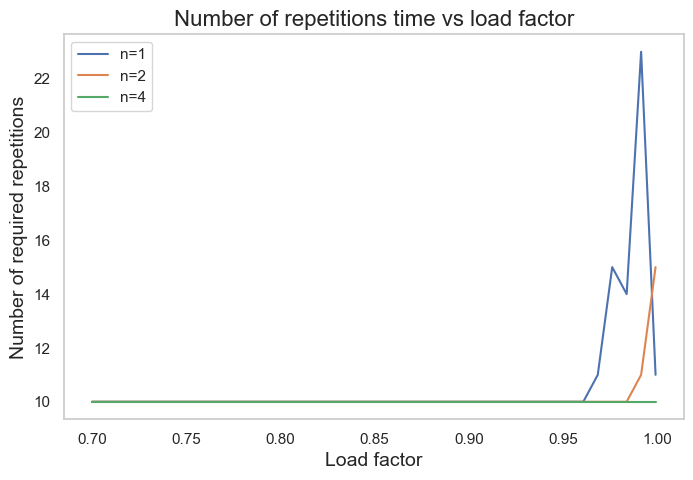

In [86]:
# Number of measurements vs load factor
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 2 # Service rate

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 3
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

results = pd.DataFrame(columns=['n', 'load', 'avg_customers_served', 'avg_waiting_time', 'repetitions'])

for n in [1, 2, 4]:
    for LOAD in np.linspace(0.7, 0.999, 40):
        avg_customers_served = []
        avg_waiting_times = []
        
        while True:
            LAMBDA = MU * LOAD * n

            env = simpy.Environment()
            bank = Bank(env, n, MU)

            env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
            env.run()

            avg_customers_served.append(bank.customers_served)
            avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))

            # Only start checking after 100 repetitions
            if len(avg_waiting_times) < 10:
                continue

            # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
            S = np.std(avg_waiting_times, ddof=1)

            if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
                break
        
        results.loc[len(results) - 1] = {
            'n': n,
            'load': LOAD,
            'avg_customers_served': np.mean(avg_customers_served),
            'avg_waiting_time': np.mean(avg_waiting_times),
            'repetitions': len(avg_waiting_times)
        }
        
results_n1 = results[results['n'] == 1]
results_n2 = results[results['n'] == 2]
results_n4 = results[results['n'] == 4]

# Plot results
plt.figure(figsize=(8, 5))
plt.title("Number of repetitions time vs load factor", fontsize = 16)
plt.xlabel("Load factor", fontsize = 14)
plt.ylabel("Number of required repetitions", fontsize = 14)
plt.grid()
plt.plot(results_n1['load'], results_n1['repetitions'], label="n=1")
plt.plot(results_n2['load'], results_n2['repetitions'], label="n=2")
plt.plot(results_n4['load'], results_n4['repetitions'], label="n=4")
plt.legend()
plt.show()


In [87]:
results

,n,load,avg_customers_served,avg_waiting_time,repetitions
-1,1,0.700000,702.1,1.189141,10
0,1,0.707667,709.6,1.149282,10
1,1,0.715333,713.1,1.290608,10
2,1,0.723000,713.0,1.305986,10
3,1,0.730667,725.4,1.384949,10
...,...,...,...,...,...
114,4,0.968333,3887.5,3.998066,10
115,4,0.976000,3847.2,1.989160,10
116,4,0.983667,3941.9,4.196139,10
117,4,0.991333,3950.2,3.341024,10


#### How many simulations do we need to get CI_radius down to 1

In [150]:
# Number of measurements vs load factor
RANDOM_SEED = 42
SIMULATION_TIME = 5000

MU = 1/10 # Service rate

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 1
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

results = pd.DataFrame(columns=['n', 'load', 'avg_customers_served', 'avg_waiting_time', 'repetitions'])

for n in [1, 2, 4]:
    for LOAD in np.linspace(0.7, 0.999, 40):
        avg_customers_served = []
        avg_waiting_times = []
        
        while True:
            LAMBDA = MU * LOAD * n

            env = simpy.Environment()
            bank = Bank(env, n, MU)

            env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
            env.run()

            avg_customers_served.append(bank.customers_served)
            avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))

            # Only start checking after 100 repetitions
            if len(avg_waiting_times) < 100:
                continue

            # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
            S = np.std(avg_waiting_times, ddof=1)

            if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
                break
        
        results.loc[len(results) - 1] = {
            'n': n,
            'load': LOAD,
            'avg_customers_served': np.mean(avg_customers_served),
            'avg_waiting_time': np.mean(avg_waiting_times),
            'repetitions': len(avg_waiting_times)
        }

results_n1 = results[results['n'] == 1]
results_n2 = results[results['n'] == 2]
results_n4 = results[results['n'] == 4]

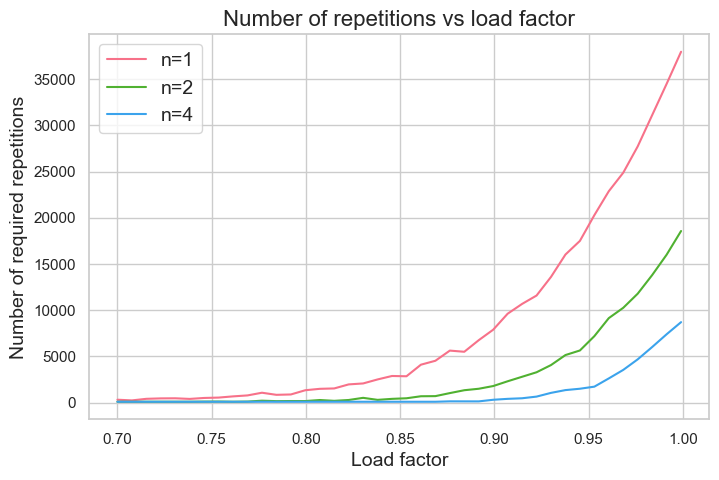

In [151]:
# Plot results
palette = sns.color_palette("husl", n_colors=3)
plt.figure(figsize=(8, 5))
plt.title("Number of repetitions vs load factor", fontsize=16)
plt.xlabel("Load factor", fontsize=14)
plt.ylabel("Number of required repetitions", fontsize=14)
plt.grid(True)
plt.plot(results_n1['load'], results_n1['repetitions'], label="n=1", color=palette[0])
plt.plot(results_n2['load'], results_n2['repetitions'], label="n=2", color=palette[1])
plt.plot(results_n4['load'], results_n4['repetitions'], label="n=4", color=palette[2])
plt.legend(fontsize=14)
plt.savefig("2.4 CLT to 1.jpg", dpi=300)
plt.show()

--------
## Q3. Explanation
For the shortest job first scheduling, we edited the initial class 'Bank' and function 'customer'. The 'Bank' class now has a 'priority' parameter that takes either "FIFO" or "SJF" and changes the counter 'simpy.Resource' to a 'simpy.PriorityResource' if its an SJF. The 'customer' function checks the priority from the bank object, and if this is an "SJF" bank, it creates requests with priority equal to the predetermined service time. Since smaller priority values are put at the front of the line, this means that the shortest job is serviced first.

In the next code block we give an example usage (seed = 42). Customers 3, 4, 5, 6 and 7 all arrive during customer 2's (considerable) service time. After customer 2 is finished, customer 5 is serviced first since they have the lowest service time (0.2689). Customers 4, 7 and 3 follow shortly, also in order of shortest service time.

When comparing the load to the number of repetitions required to reach the 95% significance, we change the confidence interval radius to 1 because the SJF queues turned out to reach the 95% significance within 50 repetitions in a lot of cases.

### Box Plot

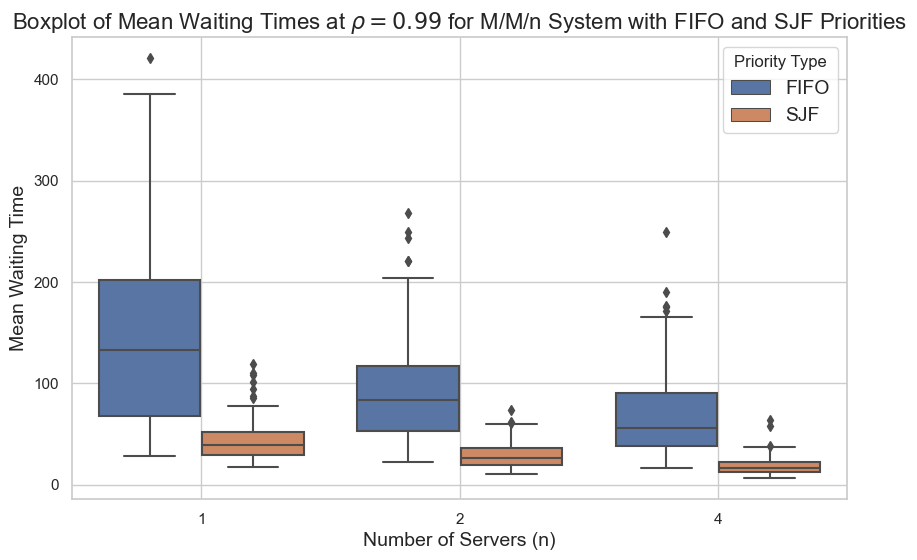

In [90]:
# Define the simulation function for FIFO and SJF
def simulate(env, num_counters, service_rate, arrival_rate, priority_type, simulation_time):
    bank = Bank(env, num_counters, service_rate, priority_type)
    env.process(setup(env, bank, simulation_time, arrival_rate))
    env.run()
    return np.mean(bank.waiting_times)

# Set the random seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Simulation parameters
MU = 1/10
SIMULATION_TIME = 5000
NUM_SIMULATIONS = 100
CONFIDENCE_LEVEL = 0.95
n_values = [1, 2, 4]
priority_types = ["FIFO", "SJF"]
RHO = 0.99

# Initialize results storage
waiting_times_data = {
    'Priority': [],
    'Servers': [],
    'WaitingTime': []
}

# Perform simulations
# Perform simulations and collect mean waiting times
for priority_type in priority_types:
    for n in n_values:
        # Set the arrival rate based on RHO and number of servers
        arrival_rate = RHO * MU * n
        
        # Run the simulations and collect mean waiting times
        mean_waiting_times = []
        for _ in range(NUM_SIMULATIONS):
            env = simpy.Environment()
            mean_waiting_time = simulate(env, n, MU, arrival_rate, priority_type, SIMULATION_TIME)
            mean_waiting_times.append(mean_waiting_time)
        
        # Store the mean waiting times data
        waiting_times_data['Priority'].extend([priority_type] * NUM_SIMULATIONS)
        waiting_times_data['Servers'].extend([n] * NUM_SIMULATIONS)
        waiting_times_data['WaitingTime'].extend(mean_waiting_times)

# Convert collected data to DataFrame
waiting_times_df = pd.DataFrame(waiting_times_data)

# Create a boxplot with annotated mean values
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(data=waiting_times_df, x='Servers', y='WaitingTime', hue='Priority')

# Set the title and labels
plt.title('Boxplot of Mean Waiting Times at $\\rho=0.99$ for M/M/n System with FIFO and SJF Priorities', fontsize=16)
plt.xlabel('Number of Servers (n)', fontsize=14)
plt.ylabel('Mean Waiting Time', fontsize=14)
plt.legend(title='Priority Type', fontsize=14)
plt.grid(True)
plt.savefig("3.1 boxplot.jpg", dpi=300)
plt.show()

### For different $\rho$:
#### Mean waiting time & Variance

In [91]:
# Define the parameters for the simulation
RANDOM_SEED = 42
MU = 1/10  # Service rate
SIMULATION_TIME = 5000  # Total time for each simulation
NUM_SIMULATIONS = 100  # Number of simulations per load factor
n_values = [1, 2, 4]  # Different numbers of servers to simulate
priority_types = ["FIFO", "SJF"]  # Types of queueing disciplines
rho_values = np.linspace(0.1, 0.99, 99)  # Load factors

# Set the random seed for reproducibility
random.seed(RANDOM_SEED)

# Initialize a dictionary to store the simulation results
waiting_times_results = {
    'Priority': [],
    'Servers': [],
    'Rho': [],
    'Mean Waiting Time': [],
    'Variance Waiting Time': []
}

# Run the simulations across all combinations of priority type, number of servers, and rho values
for priority_type in priority_types:
    for n in n_values:
        for rho in rho_values:
            # Calculate the arrival rate for the given rho and number of servers
            arrival_rate = rho * MU * n
            
            # Initialize a list to store waiting times for each simulation
            simulation_waiting_times = []
            
            # Run the specified number of simulations and collect the waiting times
            for _ in range(NUM_SIMULATIONS):
                env = simpy.Environment()
                # Assuming simulate function returns the mean waiting time for the simulation
                mean_waiting_time = simulate(env, n, MU, arrival_rate, priority_type, SIMULATION_TIME)
                simulation_waiting_times.append(mean_waiting_time)
            
            # Calculate the mean and variance of the collected mean waiting times
            mean_of_means = np.mean(simulation_waiting_times)
            variance_of_means = np.var(simulation_waiting_times)
            
            # Append the results to the waiting_times_results dictionary
            waiting_times_results['Priority'].append(priority_type)
            waiting_times_results['Servers'].append(n)
            waiting_times_results['Rho'].append(rho)
            waiting_times_results['Mean Waiting Time'].append(mean_of_means)
            waiting_times_results['Variance Waiting Time'].append(variance_of_means)


# Convert the results dictionary to a DataFrame for analysis and plotting
df_waiting_times_results = pd.DataFrame(waiting_times_results)




KeyboardInterrupt: 

In [ ]:
# Create a 1x2 subplot structure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Set the font sizes
title_fontsize = 18
label_fontsize = 16
legend_fontsize = 11

# Set color palette for the number of servers
palette = sns.color_palette("husl", n_colors=len(n_values))

# Plot the mean waiting time on the left axis (ax1)
ax1 = axes[0]
for i, n in enumerate(n_values):
    # Filter the dataframe for FIFO and plot
    subset_fifo = df_waiting_times_results[(df_waiting_times_results['Priority'] == 'FIFO') & (df_waiting_times_results['Servers'] == n)]
    ax1.plot(subset_fifo['Rho'], subset_fifo['Mean Waiting Time'], label=f'FIFO n={n}', color=palette[i], linestyle='-')
    
    # Filter the dataframe for SJF and plot
    subset_sjf = df_waiting_times_results[(df_waiting_times_results['Priority'] == 'SJF') & (df_waiting_times_results['Servers'] == n)]
    ax1.plot(subset_sjf['Rho'], subset_sjf['Mean Waiting Time'], label=f'SJF n={n}', color=palette[i], linestyle='--')

ax1.set_title('Mean Waiting Time for Multiple Values of ρ', fontsize=title_fontsize)
ax1.set_xlabel('ρ (System Load)', fontsize=label_fontsize)
ax1.set_ylabel('Mean Waiting Time (seconds)', fontsize=label_fontsize)
ax1.legend(fontsize=legend_fontsize)
ax1.grid(True)

# Plot the variance of waiting time on the right axis (ax2)
ax2 = axes[1]
for i, n in enumerate(n_values):
    # Filter the dataframe for FIFO and plot
    subset_fifo = df_waiting_times_results[(df_waiting_times_results['Priority'] == 'FIFO') & (df_waiting_times_results['Servers'] == n)]
    ax2.plot(subset_fifo['Rho'], subset_fifo['Variance Waiting Time'], label=f'FIFO n={n}', color=palette[i], linestyle='-')
    
    # Filter the dataframe for SJF and plot
    subset_sjf = df_waiting_times_results[(df_waiting_times_results['Priority'] == 'SJF') & (df_waiting_times_results['Servers'] == n)]
    ax2.plot(subset_sjf['Rho'], subset_sjf['Variance Waiting Time'], label=f'SJF n={n}', color=palette[i], linestyle='--')

ax2.set_title('Variance of Waiting Time for Multiple Values of ρ', fontsize=title_fontsize)
ax2.set_xlabel('ρ (System Load)', fontsize=label_fontsize)
ax2.set_ylabel('Variance of Waiting Time', fontsize=label_fontsize)
ax2.set_yscale('log')
ax2.legend(fontsize=legend_fontsize)
ax2.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig("3.2 mean and variance.jpg", dpi=300)
plt.show()

#### Confidence Interval Analysis

In [ ]:
# Function to calculate the CI
def calculate_ci(average_times, confidence=0.95):
    n = len(average_times)
    mean = np.mean(average_times)
    sem = np.std(average_times, ddof=1) / np.sqrt(n)
    margin = sem * norm.ppf((1 + confidence) / 2)
    return margin

# Set parameters
RANDOM_SEED = 42
MU = 1/10  # Service rate
SIMULATION_TIME = 5000  # Total time for each simulation
NUM_SIMULATIONS = 100  # Number of simulations per load factor
CONFIDENCE = 0.95  # Confidence level for CI
n_values = [1, 2, 4]  # Different numbers of servers to simulate
priority_types = ["FIFO", "SJF"]  # Types of queueing disciplines
rho_values = np.linspace(0.1, 0.99, 40)  # Load factors

# Set random seed
random.seed(RANDOM_SEED)

# Store CI radius results
ci_radius_results = {'n': [], 'ci_radius': [], 'priority': [], 'rho': []}

# Perform simulations
for priority_type in priority_types:
    for n in n_values:
        for rho in rho_values:
            arrival_rate = MU * n * rho
            average_times = []
            for _ in range(NUM_SIMULATIONS):
                env = simpy.Environment()
                avg_time = simulate(env, n, MU, arrival_rate, priority_type, SIMULATION_TIME)
                average_times.append(avg_time)
            ci_radius = calculate_ci(average_times, CONFIDENCE)
            ci_radius_results['n'].append(n)
            ci_radius_results['ci_radius'].append(ci_radius)
            ci_radius_results['priority'].append(priority_type)
            ci_radius_results['rho'].append(rho)

# Define a color for each 'n' value
palette = sns.color_palette("husl", n_colors=len(n_values))

# Start plotting
plt.figure(figsize=(14, 7))

# Plot settings
title_fontsize = 16
label_fontsize = 14
legend_fontsize = 12
line_styles = {"FIFO": "-", "SJF": "--"}  # Solid line for FIFO, dashed line for SJF

# We iterate over priority types and 'n' values to plot the mean and variance
for i, n in enumerate(n_values):
    # Filter the data for FIFO and SJF
    fifo_data = [ci_radius_results['ci_radius'][j] for j in range(len(ci_radius_results['n'])) 
                 if ci_radius_results['n'][j] == n and ci_radius_results['priority'][j] == "FIFO"]
    sjf_data = [ci_radius_results['ci_radius'][j] for j in range(len(ci_radius_results['n'])) 
                if ci_radius_results['n'][j] == n and ci_radius_results['priority'][j] == "SJF"]
    
    # Plot FIFO with solid lines
    plt.plot(rho_values, fifo_data, label=f'FIFO n={n}', color=palette[i], linestyle=line_styles["FIFO"])
    
    # Plot SJF with dashed lines
    plt.plot(rho_values, sjf_data, label=f'SJF n={n}', color=palette[i], linestyle=line_styles["SJF"])

plt.title('Confidence Interval Radius vs Load Factor for FIFO and SJF', fontsize=title_fontsize)
plt.xlabel('ρ (System Load)', fontsize=label_fontsize)
plt.ylabel('Confidence Interval Radius', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.savefig("3.3 ci.jpg", dpi=300)
plt.show()


In [ ]:
# Example usage:
RANDOM_SEED = 42
LAMBDA = 1/12 # Arrival rate
MU = 1/10 # Service rate
SIMULATION_TIME = 50
n = 1 # Number of counters

LOAD = LAMBDA/(MU * n) # Load of the system, should be < 1 for stable system

print(f"M/M/1 queue simulation with λ={LAMBDA}, μ={MU}, ρ = {LOAD}")
print(f"Simulation time: {SIMULATION_TIME}")

random.seed(RANDOM_SEED)
env = simpy.Environment()

bank = Bank(env, n, MU, priority="SJF")

env.process(setup(env, bank, SIMULATION_TIME, LAMBDA, print_all=True))
env.run()

print(f"Customers served: {bank.customers_served}")
print(f"Average waiting time: {sum(bank.waiting_times)/len(bank.waiting_times)}")

#### How many simulations we need to get CI radius down to 1

In [ ]:
# Number of measurements vs load factor
RANDOM_SEED = 42
SIMULATION_TIME = 5000

MU = 1/10 # Service rate

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 1
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

results = pd.DataFrame(columns=['priority', 'n', 'load', 'avg_customers_served', 'avg_waiting_time', 'repetitions'])

for priority in ['FIFO', 'SJF']:
    for n in [1, 2, 4]:
        for LOAD in np.linspace(0.7, 0.999, 40):
            avg_customers_served = []
            avg_waiting_times = []
            
            while True:
                LAMBDA = MU * LOAD * n

                env = simpy.Environment()
                bank = Bank(env, n, MU, priority=priority)

                env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
                env.run()

                avg_customers_served.append(bank.customers_served)
                avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))

                # Only start checking after 100 repetitions
                if len(avg_waiting_times) < 50:
                    continue

                # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
                S = np.std(avg_waiting_times, ddof=1)

                if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
                    break
            
            results.loc[len(results) - 1] = {
                'priority': priority,
                'n': n,
                'load': LOAD,
                'avg_customers_served': np.mean(avg_customers_served),
                'avg_waiting_time': np.mean(avg_waiting_times),
                'repetitions': len(avg_waiting_times)
            }

# Define color palette and line styles
palette = sns.color_palette("husl", n_colors=3)  # One color for each value of 'n'
line_styles = {"FIFO": "-", "SJF": "--"}  # Solid line for FIFO, dashed line for SJF

# Plot results
plt.figure(figsize=(8, 5))
for i, n in enumerate([1, 2, 4]):
    # Select data for FIFO and SJF with the current value of 'n'
    fifo_data = results[(results['priority'] == "FIFO") & (results['n'] == n)]
    sjf_data = results[(results['priority'] == "SJF") & (results['n'] == n)]
    
    # Plot FIFO with solid line
    plt.plot(fifo_data['load'], fifo_data['repetitions'], label=f"FIFO, n={n}", 
             color=palette[i], linestyle=line_styles["FIFO"])
    
    # Plot SJF with dashed line
    plt.plot(sjf_data['load'], sjf_data['repetitions'], label=f"SJF, n={n}", 
             color=palette[i], linestyle=line_styles["SJF"])

plt.title("Number of repetitions vs load factor", fontsize=16)
plt.xlabel("ρ (System Load)", fontsize=14)
plt.ylabel("Number of required repetitions", fontsize=14)
plt.grid(True)
plt.legend()
plt.savefig("3.4 ci to 1.jpg", dpi=300)
plt.show()

## Q4

### For system

#### Plotting the box plot of three service type when server number = [1,2,4]

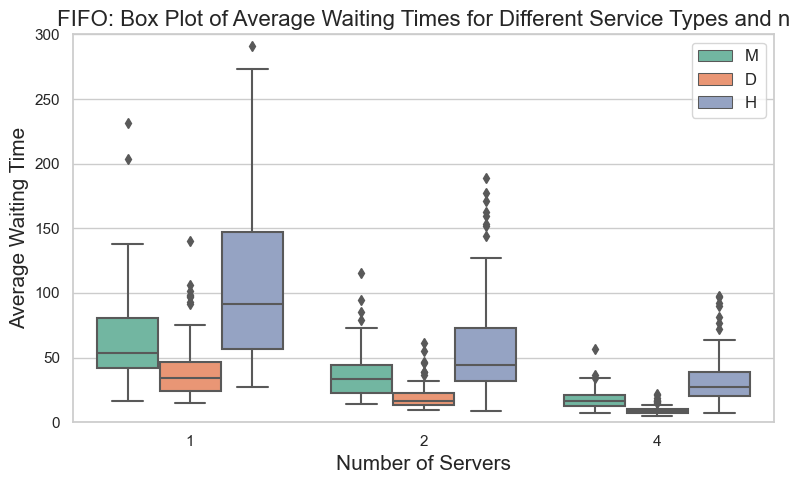

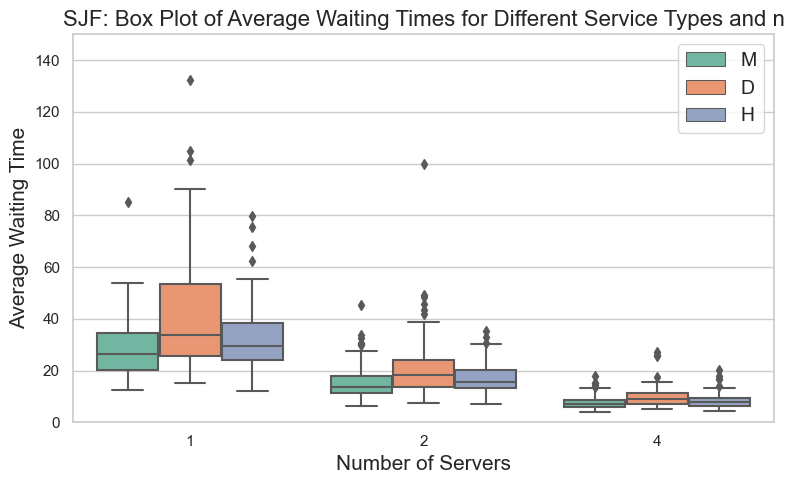

In [93]:
def run_simulation(num_servers, service_type, priority):
    avg_waiting_times = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        bank = Bank(env, num_servers, MU, priority=priority, service_type=service_type)
        env.process(setup(env, bank, SIMULATION_TIME, num_servers * MU * 0.9))
        env.run()
        avg_waiting_times.append(np.mean(bank.waiting_times))
    return avg_waiting_times


# Parameters for the simulation
MU = 1/10 # Service rate
SIMULATION_TIME = 5000
SIMULATIONS = 100
servers = [1, 2, 4]

# Dictionary to hold simulation results
simulation_results = {}

# Run simulations for different numbers of servers
service_types = ["M", "D", "H"]
priorities = ["FIFO", "SJF"]

for priority in priorities:
    for service_type in service_types:
        for num_servers in servers:
            key = (priority, service_type, num_servers)
            simulation_results[key] = run_simulation(num_servers, service_type, priority)

# Prepare data
data_for_plot = []
for (priority, service_type, num_servers), times in simulation_results.items():
    for time in times:
        data_for_plot.append({'Priority': priority,
                              'Server': f'{num_servers}', 
                              'ServiceType': service_type, 
                              'MeanWaitingTime': time})

# Create DataFrame
df_plot = pd.DataFrame(data_for_plot)


plt.figure(figsize=(8, 5))
sns.boxplot(x='Server', y='MeanWaitingTime', hue='ServiceType',
            data=df_plot[df_plot['Priority'] == 'FIFO'],
            palette='Set2', hue_order=['M', 'D', 'H'])
plt.legend(title='Service Type')
plt.title('FIFO: Box Plot of Average Waiting Times for Different Service Types and n', fontsize=16)
plt.xlabel('Number of Servers', fontsize=15)
plt.ylabel('Average Waiting Time', fontsize=15)
plt.ylim(0, 300)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.savefig("4.1.1 boxplotfifo.jpg", dpi=300)
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='Server', y='MeanWaitingTime', hue='ServiceType',
            data=df_plot[df_plot['Priority'] == 'SJF'],
            palette='Set2', hue_order=['M', 'D', 'H'])
plt.legend(title='Service Type')
plt.title('SJF: Box Plot of Average Waiting Times for Different Service Types and n', fontsize=16)
plt.xlabel('Number of Servers', fontsize=15)
plt.ylabel('Average Waiting Time', fontsize=15)
plt.ylim(0, 150)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.savefig("4.1.2 boxplotsjf.jpg", dpi=300)
plt.show()


#### For different $\rho$:
##### Mean waiting time & Variance

In [148]:
def simulate(env, num_counters, service_rate, arrival_rate, priority_type, simulation_time, service_type):
    bank = Bank(env, num_counters, service_rate, priority_type, service_type)
    env.process(setup(env, bank, simulation_time, arrival_rate))
    env.run()
    return np.mean(bank.waiting_times)

# Define the parameters for the simulation
RANDOM_SEED = 42
MU = 1/10  # Service rate
SIMULATION_TIME = 5000  # Total time for each simulation
NUM_SIMULATIONS = 100  # Number of simulations per load factor
n_values = [1, 2, 4]  # Different numbers of servers to simulate
priority_types = ["FIFO", "SJF"]  # Types of queueing disciplines
rho_values_1 = np.linspace(0.1, 0.9, 10)  
rho_values_2 = np.linspace(0.91, 0.99, 10)  
rho_values = np.concatenate((rho_values_1, rho_values_2))

# Set the random seed for reproducibility
random.seed(RANDOM_SEED)

# Initialize a dictionary to store the simulation results
waiting_times_results = {
    'Priority': [],
    'Servers': [],
    'Rho': [],
    'Mean': [],
    'Variance': [],
    'Service Type' : []
}
service_types = ["M", "D", "H"]
# Run the simulations across all combinations of priority type, number of servers, and rho values
for service_type in service_types:
    for priority_type in priority_types:
        for n in n_values:
            for rho in rho_values:
                # Calculate the arrival rate for the given rho and number of servers
                arrival_rate = rho * MU * n
                
                # Initialize a list to store waiting times for each simulation
                simulation_waiting_times = []
                
                # Run the specified number of simulations and collect the waiting times
                for _ in range(NUM_SIMULATIONS):
                    env = simpy.Environment()
                    # Assuming simulate function returns the mean waiting time for the simulation
                    mean_waiting_time = simulate(env, n, MU, arrival_rate, priority_type, SIMULATION_TIME, service_type)
                    simulation_waiting_times.append(mean_waiting_time)
                
                # Calculate the mean and variance of the collected mean waiting times
                mean_of_means = np.mean(simulation_waiting_times)
                variance_of_means = np.var(simulation_waiting_times)
                
                # Append the results to the waiting_times_results dictionary
                waiting_times_results['Priority'].append(priority_type)
                waiting_times_results['Servers'].append(n)
                waiting_times_results['Rho'].append(rho)
                waiting_times_results['Mean'].append(mean_of_means)
                waiting_times_results['Variance'].append(variance_of_means)
                waiting_times_results['Service Type'].append(service_type)

# Convert the results dictionary to a DataFrame for analysis and plotting
df_waiting_times_results = pd.DataFrame(waiting_times_results)

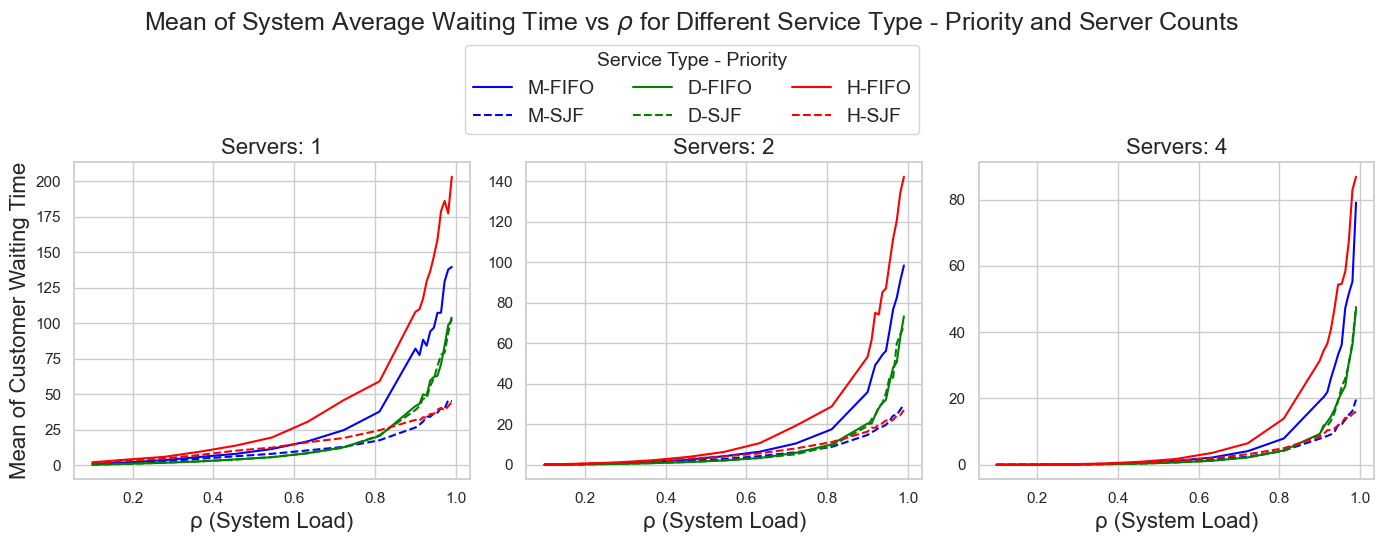

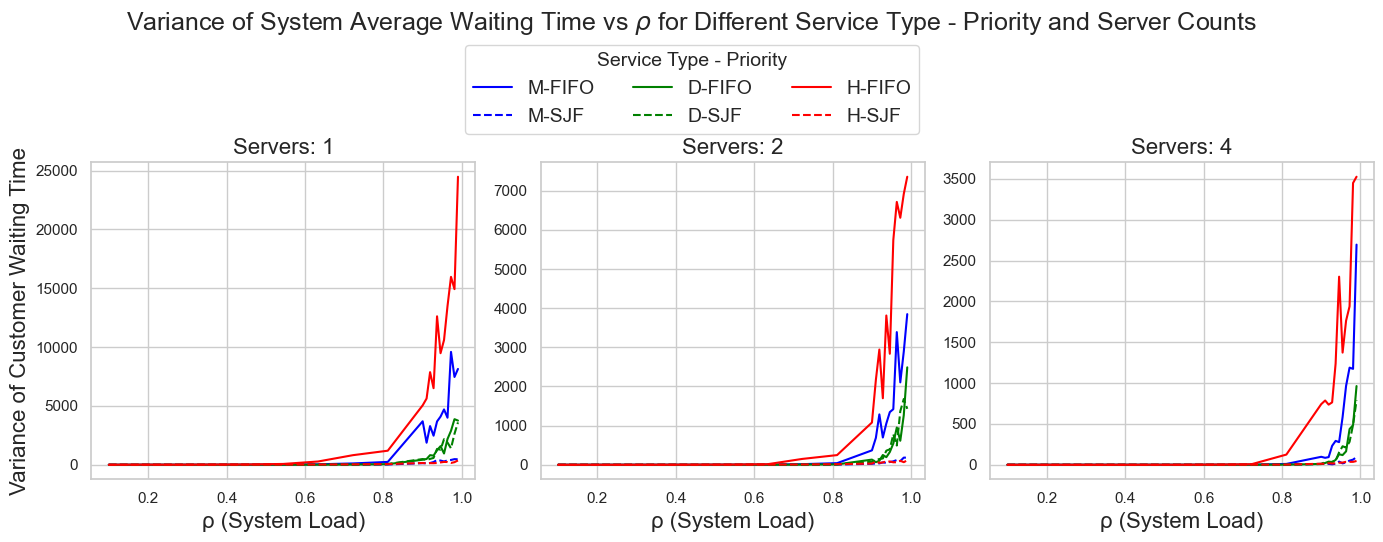

In [149]:
# Define colors corresponding to each service type
colors = {'M': 'blue', 'D': 'green', 'H': 'red'}
service_types = ["M", "D", "H"]
# Define line styles corresponding to priority
linestyles = {'FIFO': 'solid', 'SJF': 'dashed'}
vertical_axis_objects = ['Mean', 'Variance']
for vertical_axis_object in vertical_axis_objects:
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))

    # Create a handle list for legends
    handles_list = []

    # Plot the subplot for mean waiting time
    for i, servers in enumerate(n_values):
        ax = axes[i]
        
        for service_type in service_types:
            for priority in priority_types:
                # Filter data for specific conditions
                mask = (df_waiting_times_results['Servers'] == servers) & \
                    (df_waiting_times_results['Service Type'] == service_type) & \
                    (df_waiting_times_results['Priority'] == priority)
                subset = df_waiting_times_results[mask]
                
                # Plot the line graph of rho vs. mean waiting time
                handle, = ax.plot(subset['Rho'], subset[vertical_axis_object],
                                label=f'{service_type}-{priority}',
                                color=colors[service_type], linestyle=linestyles[priority])
                if i == 0:  # Add legend handles only in the first subplot
                    handles_list.append(handle)
        
        ax.set_title(f'Servers: {servers}', fontsize=16)
        ax.set_xlabel('ρ (System Load)', fontsize=16)
        if i == 0:
            ax.set_ylabel(vertical_axis_object +' of Customer Waiting Time', fontsize=16)

    # Add legend
    # Adjust bbox_to_anchor parameter when calling fig.legend
    fig.legend(handles=handles_list, loc='upper center', bbox_to_anchor=(0.5, 1.03),
            ncol=3, title='Service Type - Priority', title_fontsize=14, fontsize=14)

    # Adjust y parameter when calling fig.suptitle
    fig.suptitle(f"{vertical_axis_object} of System Average Waiting Time vs $\\rho$ for Different Service Type - Priority and Server Counts", fontsize=18, y=1.08)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


#### How many simulations we need to get CI radius down to 1

In [ ]:
# Number of measurements vs load factor
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 1/10 # Service rate
rho_values_1 = np.linspace(0.1, 0.9, 10)  
rho_values_2 = np.linspace(0.91, 0.99, 10)  
rho_values = np.concatenate((rho_values_1, rho_values_2))

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 1
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

service_types = ["M", "D", "H"]
all_results = []
for service_type in service_types:
    results = pd.DataFrame(columns=['priority', 'n', 'load', 'avg_customers_served', 'avg_waiting_time', 'repetitions'])
    for priority in ['FIFO', 'SJF']:
        for n in [1, 2, 4]:
            for LOAD in rho_values:
                avg_customers_served = []
                avg_waiting_times = []
                
                while True:
                    LAMBDA = MU * LOAD * n

                    env = simpy.Environment()
                    bank = Bank(env, n, MU, priority=priority, service_type = service_type)

                    env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
                    env.run()

                    avg_customers_served.append(bank.customers_served)
                    avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))

                    # Only start checking after 100 repetitions
                    if len(avg_waiting_times) < 50:
                        continue

                    # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
                    S = np.std(avg_waiting_times, ddof=1)

                    if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
                        break
                
                results.loc[len(results) - 1] = {
                    'priority': priority,
                    'n': n,
                    'load': LOAD,
                    'avg_customers_served': np.mean(avg_customers_served),
                    'avg_waiting_time': np.mean(avg_waiting_times),
                    'repetitions': len(avg_waiting_times)
                }
    all_results.append(results)

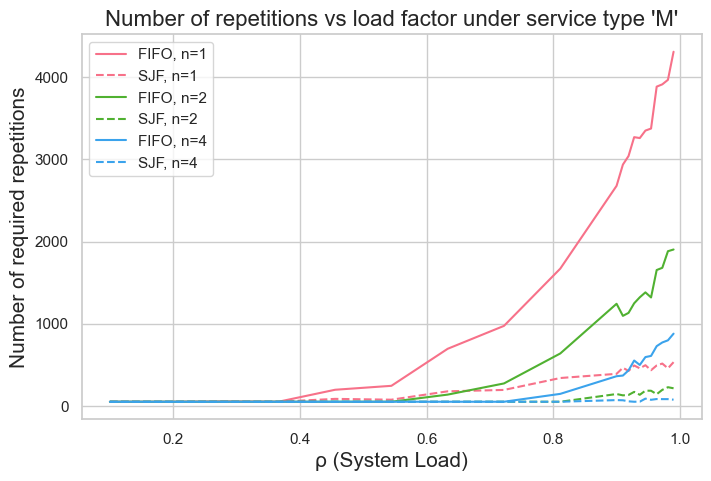

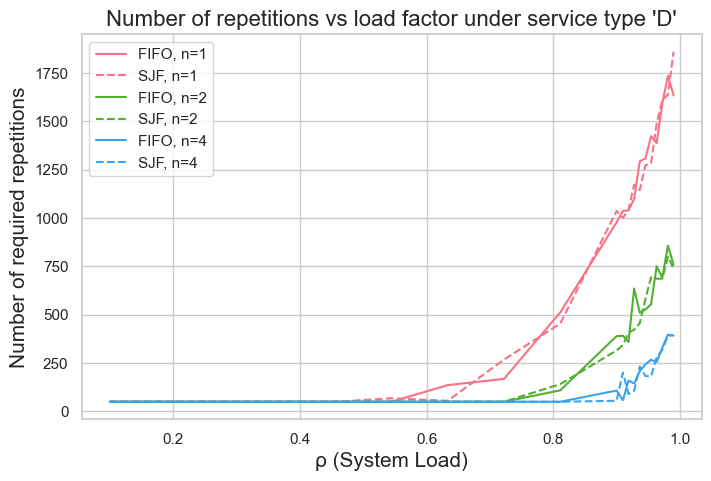

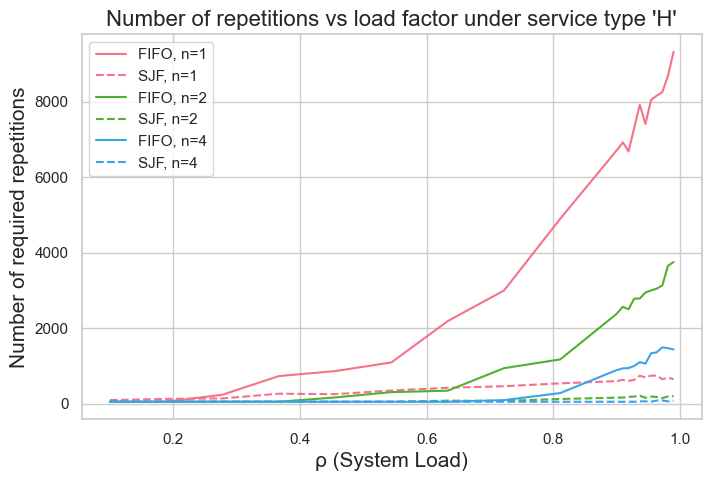

In [ ]:
for results, service_type in zip(all_results, service_types):
    # Define color palette and line styles
    palette = sns.color_palette("husl", n_colors=3)  # One color for each value of 'n'
    line_styles = {"FIFO": "-", "SJF": "--"}  # Solid line for FIFO, dashed line for SJF

    # Plot results
    plt.figure(figsize=(8, 5))
    for i, n in enumerate([1, 2, 4]):
        # Select data for FIFO and SJF with the current value of 'n'
        fifo_data = results[(results['priority'] == "FIFO") & (results['n'] == n)]
        sjf_data = results[(results['priority'] == "SJF") & (results['n'] == n)]
        
        # Plot FIFO with solid line
        plt.plot(fifo_data['load'], fifo_data['repetitions'], label=f"FIFO, n={n}", 
                color=palette[i], linestyle=line_styles["FIFO"])
        
        # Plot SJF with dashed line
        plt.plot(sjf_data['load'], sjf_data['repetitions'], label=f"SJF, n={n}", 
                color=palette[i], linestyle=line_styles["SJF"])

    plt.title(f"Number of repetitions vs load factor under service type '{service_type}'", fontsize=16)
    plt.xlabel("ρ (System Load)", fontsize=15)
    plt.ylabel("Number of required repetitions", fontsize=15)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"4.3 repetitions_vs_load_{service_type}.png", dpi=300)
    plt.show()

### For individual

#### Plot individual service times versus waiting times

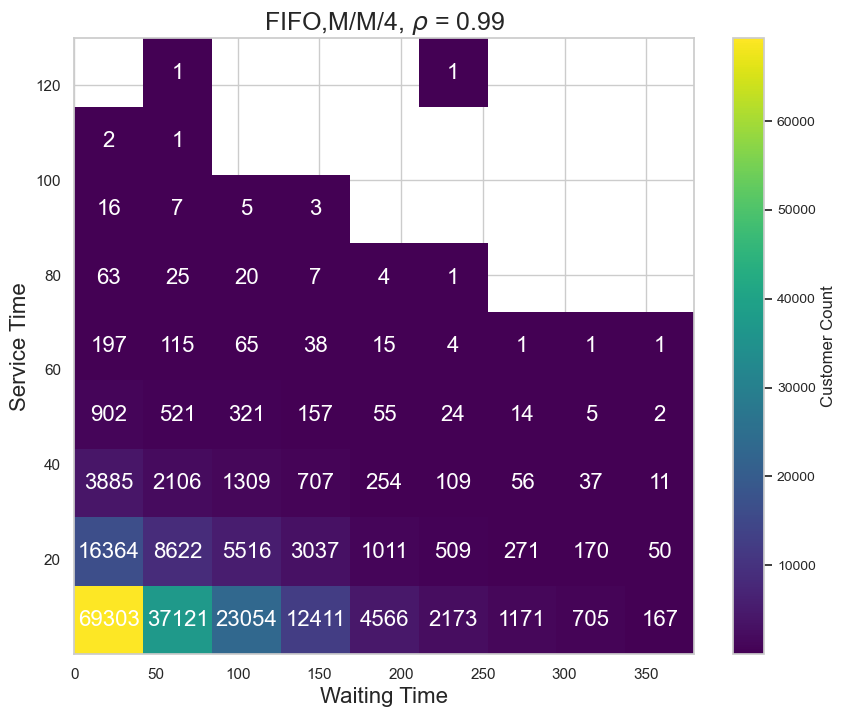

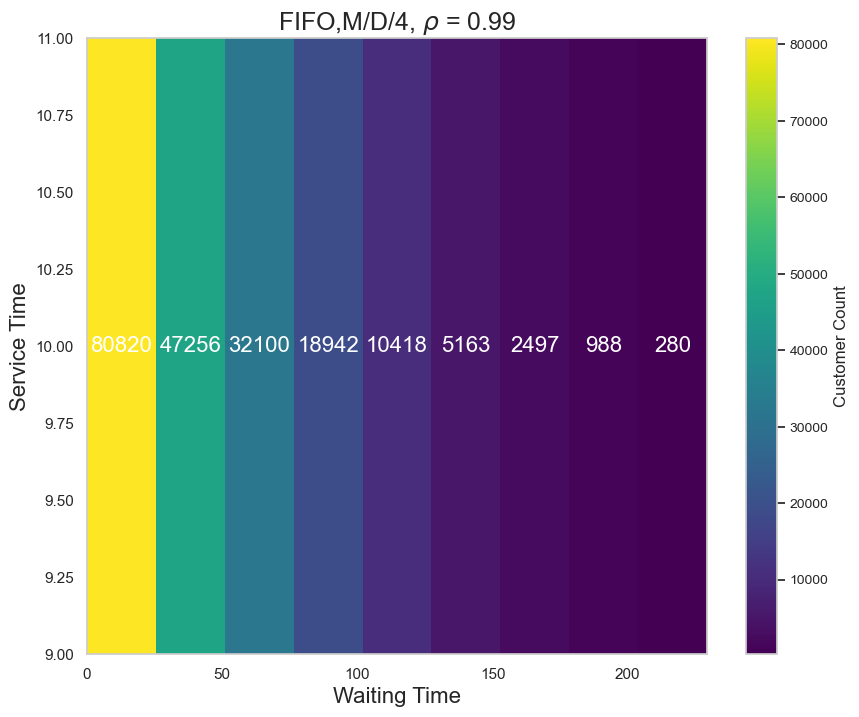

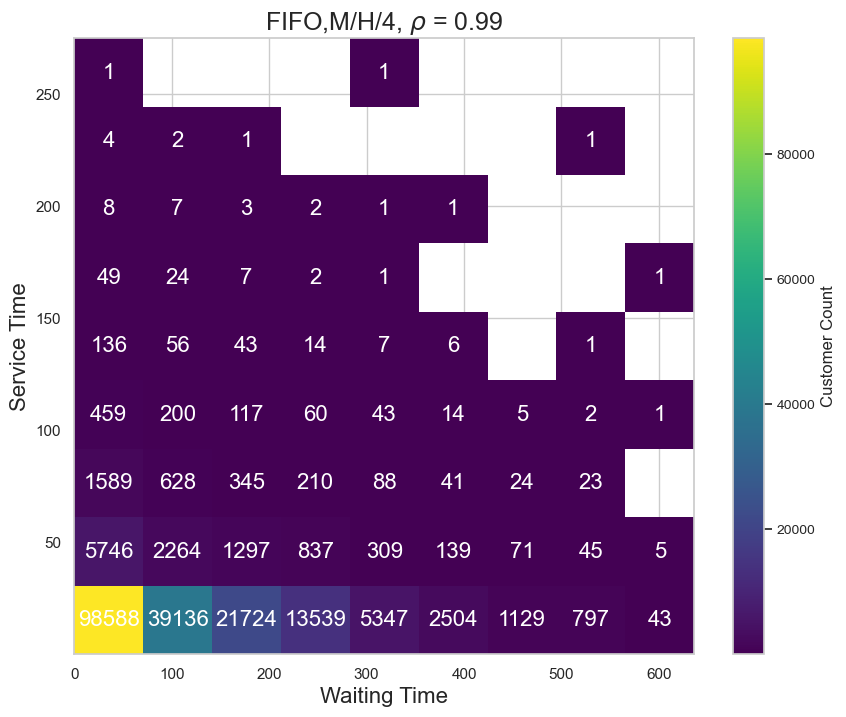

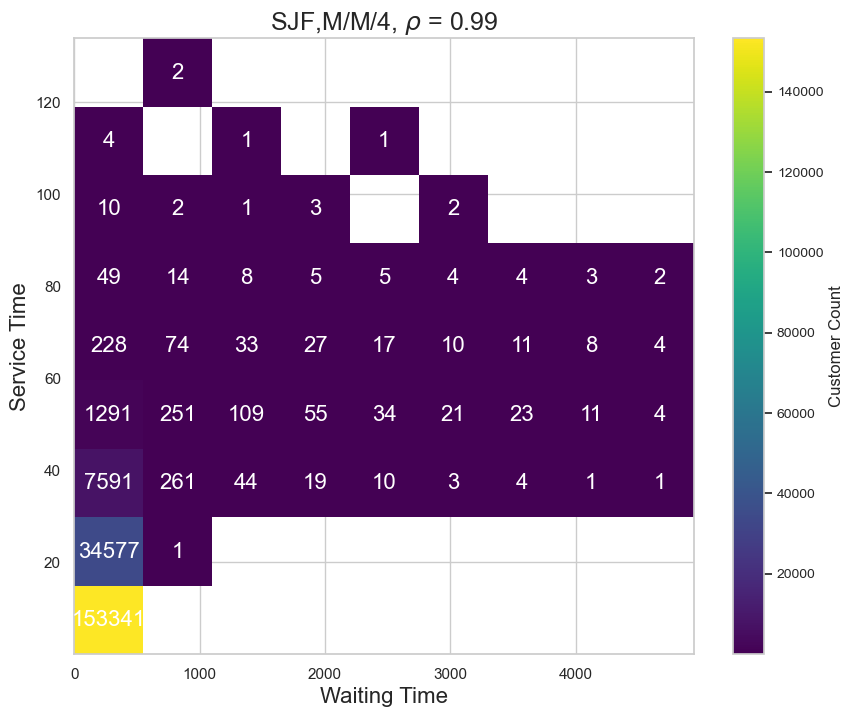

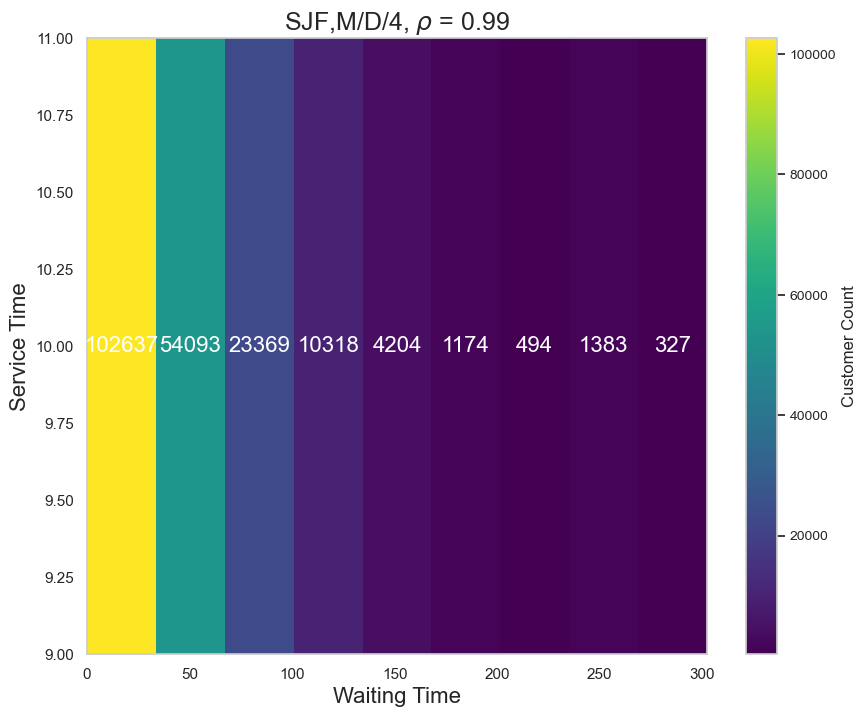

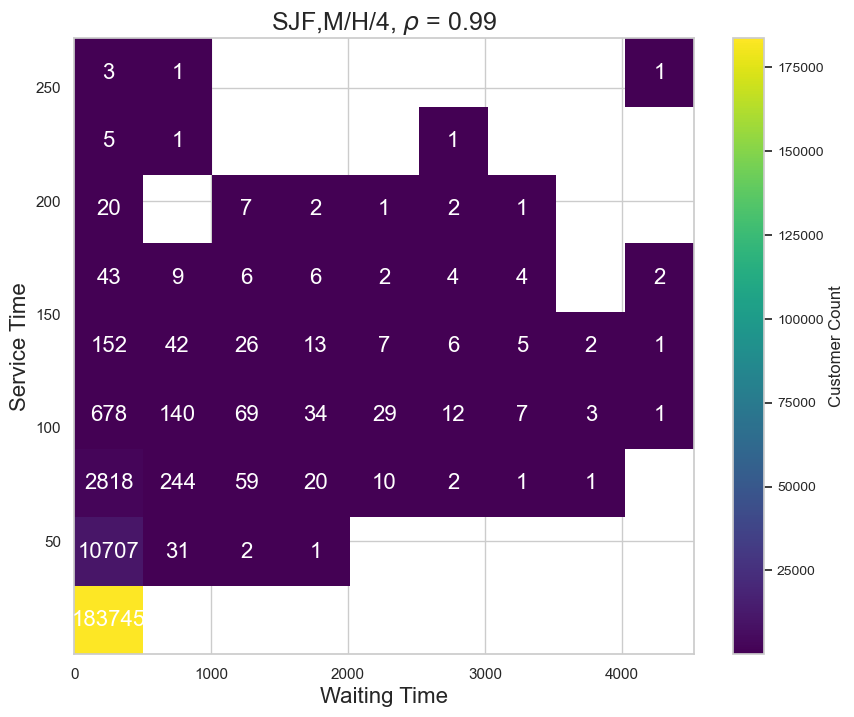

In [108]:
def run_simulation(num_servers, service_type, priority, rho):
    waiting_times = []
    service_times = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        bank = Bank(env, num_servers, MU, priority=priority, service_type=service_type)
        env.process(setup(env, bank, SIMULATION_TIME, num_servers * MU * rho))
        env.run()
        waiting_times.extend(bank.waiting_times)
        service_times.extend(bank.service_times)
    return waiting_times, service_times


# Parameters for the simulation
MU = 1/10 # Service rate
SIMULATION_TIME = 5000
SIMULATIONS = 100
rho = 0.99
servers = [4]

# Dictionary to hold simulation results
simulation_results = {}

# Run simulations for different numbers of servers
service_types = ["M", "D", "H"]
priorities = ["FIFO","SJF"]

for priority in priorities:
    for service_type in service_types:
        for num_servers in servers:
            waiting_times, service_times = run_simulation(num_servers, service_type, priority, rho)
            # Create a 2D histogram with hexagonal bins
            #plt.suptitle(f'{priority},{service_type},{num_servers}', y=1.05)  # Adjust title position
           
            x_bins = np.linspace(min(waiting_times), max(waiting_times), 10)
            y_bins = np.linspace(min(service_times), max(service_times), 10)
            # Check if the range is too small and adjust if necessary
            if np.min(waiting_times) == np.max(waiting_times):
                x_bins = [np.min(waiting_times) - 1, np.min(waiting_times) + 1]
            if np.min(service_times) == np.max(service_times):
                y_bins = [np.min(service_times) - 1, np.min(service_times) + 1]
            # Create the 2D histogram
            fig, ax = plt.subplots(figsize=(10, 8))
            hst = ax.hist2d(waiting_times, service_times, bins=[x_bins, y_bins], cmap='viridis', cmin=1)
            
            # Add color bar    
            cbar = plt.colorbar(hst[3], ax=ax)
            cbar.set_label('Customer Count', fontsize=12)  
            cbar.ax.tick_params(labelsize=10) 
           


            # Add annotation for each bin
            for i in range(len(x_bins)-1):
                for j in range(len(y_bins)-1):
                    if hst[0][i, j] > 0:  # Only annotate bins with counts
                        ax.annotate(str(int(hst[0][i, j])), 
                                    xy=((x_bins[i]+x_bins[i+1])/2, (y_bins[j]+y_bins[j+1])/2), 
                                    ha='center', va='center', color='white', fontsize=16)

            # Set labels and title
            plt.xlabel('Waiting Time', fontsize=16)
            plt.ylabel('Service Time', fontsize=16)
            plt.title(f'{priority},M/{service_type}/{num_servers}, $\\rho$ = {rho}', fontsize=18)

            plt.show()
     


#### Calculate customer waiting time variance

In [140]:
# Service rate, simulation time, and the number of simulations per scenario
MU = 1/10  # Service rate
SIMULATION_TIME = 5000
SIMULATIONS = 100
rhos = np.linspace(0.9, 0.99, 10)  # Load factors
servers = [1, 2, 4]  # Number of servers to simulate
service_types = ["M", "D", "H"]
# Dictionary to hold simulation results
simulation_results = {
    'Rho': [],
    'Priority': [],
    'ServiceType': [],
    'Servers': [],
    'Variance': [],
    'Mean':[]
}

# Run simulations for different load factors, priorities, service types, and server counts
for rho in rhos:
    for priority in priorities:
        for service_type in service_types:
            for num_servers in servers:
                # Run the simulation to get waiting times and service times
                waiting_times, _ = run_simulation(num_servers, service_type, priority, rho)
                
                # Calculate the variance of waiting times
                variance_waiting_time = np.var(waiting_times)
                mean_waiting_time = np.mean(waiting_times)
                # Store the results
                simulation_results['Rho'].append(rho)
                simulation_results['Priority'].append(priority)
                simulation_results['ServiceType'].append(service_type)
                simulation_results['Servers'].append(num_servers)
                simulation_results['Variance'].append(variance_waiting_time)
                simulation_results['Mean'].append(mean_waiting_time)

df_customer_waiting_times_results = pd.DataFrame(simulation_results)

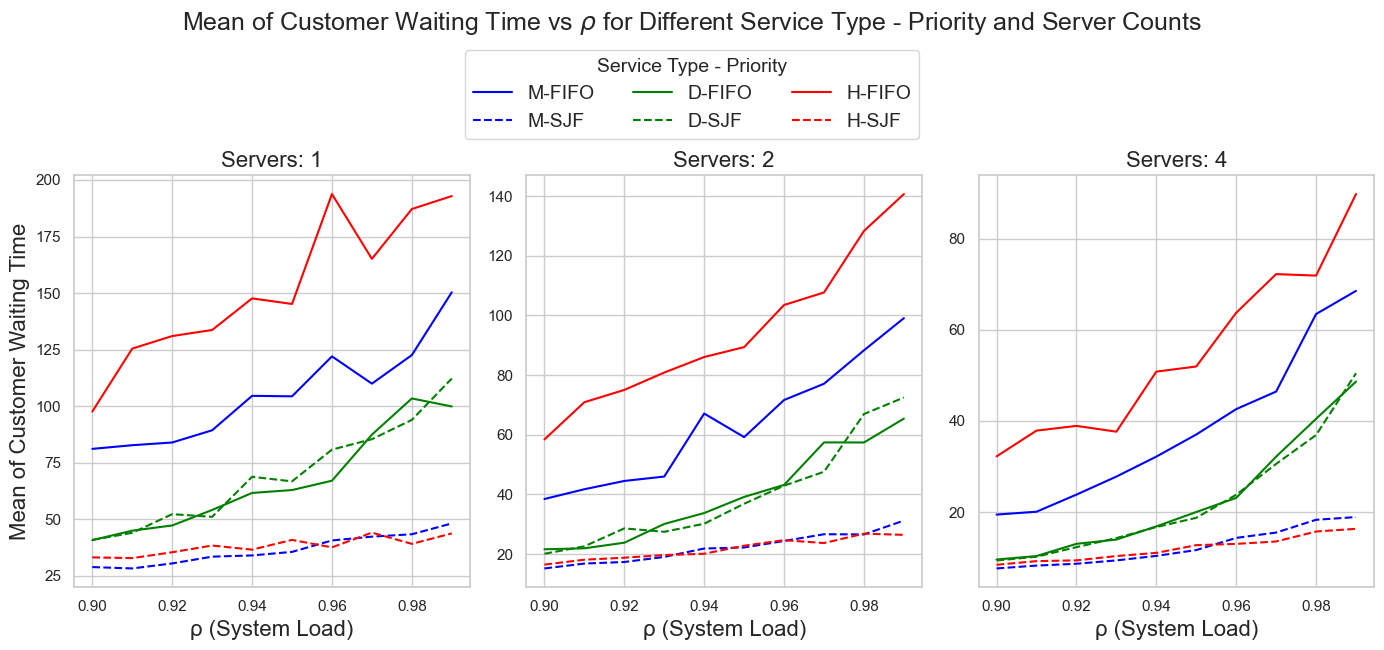

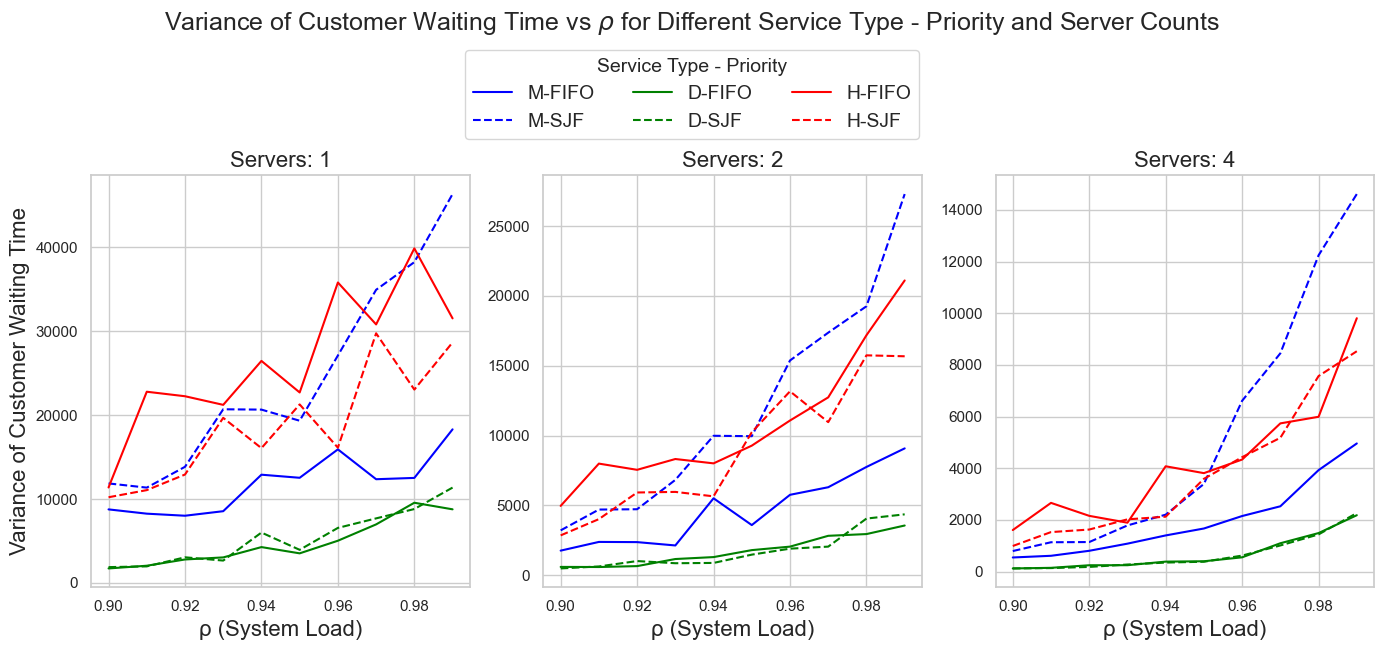

In [141]:
# Define colors corresponding to each service type
colors = {'M': 'blue', 'D': 'green', 'H': 'red'}
# Define line styles corresponding to priority
linestyles = {'FIFO': 'solid', 'SJF': 'dashed'}
vertical_axis_objects = ['Mean', 'Variance']
for vertical_axis_object in vertical_axis_objects:
    fig, axes = plt.subplots(1, 3, figsize=(14, 6))

    # Create a handle list for legends
    handles_list = []

    # Plot the subplot for mean waiting time
    for i, servers in enumerate(n_values):
        ax = axes[i]
        
        for service_type in service_types:
            for priority in priority_types:
                # Filter data for specific conditions
                mask = (df_customer_waiting_times_results['Servers'] == servers) & \
                    (df_customer_waiting_times_results['ServiceType'] == service_type) & \
                    (df_customer_waiting_times_results['Priority'] == priority)
                subset = df_customer_waiting_times_results[mask]
                
                # Plot the line graph of rho vs. mean waiting time
                handle, = ax.plot(subset['Rho'], subset[vertical_axis_object],
                                label=f'{service_type}-{priority}',
                                color=colors[service_type], linestyle=linestyles[priority])
                if i == 0:  # Add legend handles only in the first subplot
                    handles_list.append(handle)
        
        ax.set_title(f'Servers: {servers}', fontsize=16)
        ax.set_xlabel('ρ (System Load)', fontsize=16)
        if i == 0:
            ax.set_ylabel(vertical_axis_object +' of Customer Waiting Time', fontsize=16)

    # Add legend
    # Adjust bbox_to_anchor parameter when calling fig.legend
    fig.legend(handles=handles_list, loc='upper center', bbox_to_anchor=(0.5, 1.03),
            ncol=3, title='Service Type - Priority', title_fontsize=14, fontsize=14)

    # Adjust y parameter when calling fig.suptitle
    fig.suptitle(f'{vertical_axis_object} of Customer Waiting Time vs $\\rho$ for Different Service Type - Priority and Server Counts', fontsize=18, y=1.08)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



#### Focus on a balance between customer waiting_time variance and mean in MM system

In [143]:
# Service rate, simulation time, and the number of simulations per scenario
MU = 1/10  # Service rate
SIMULATION_TIME = 5000
SIMULATIONS = 100
rhos = np.linspace(0.9, 0.99, 10)  # Load factors
servers = [1, 2, 4]  # Number of servers to simulate
service_types = ["M"]
priorities = ["FIFO", "SJF", "MIX50%", "MIX100%", "MIX150%", "MIX200%"]
# Dictionary to hold simulation results
simulation_results = {
    'Rho': [],
    'Priority': [],
    'ServiceType': [],
    'Servers': [],
    'Variance': [],
    'Mean':[]
}

# Run simulations for different load factors, priorities, service types, and server counts
for rho in rhos:
    for priority in priorities:
        for service_type in service_types:
            for num_servers in servers:
                # Run the simulation to get waiting times and service times
                waiting_times, _ = run_simulation(num_servers, service_type, priority, rho)
                
                # Calculate the variance of waiting times
                variance_waiting_time = np.var(waiting_times)
                mean_waiting_time = np.mean(waiting_times)
                # Store the results
                simulation_results['Rho'].append(rho)
                simulation_results['Priority'].append(priority)
                simulation_results['ServiceType'].append(service_type)
                simulation_results['Servers'].append(num_servers)
                simulation_results['Variance'].append(variance_waiting_time)
                simulation_results['Mean'].append(mean_waiting_time)

df_applymix_waiting_times_results = pd.DataFrame(simulation_results)

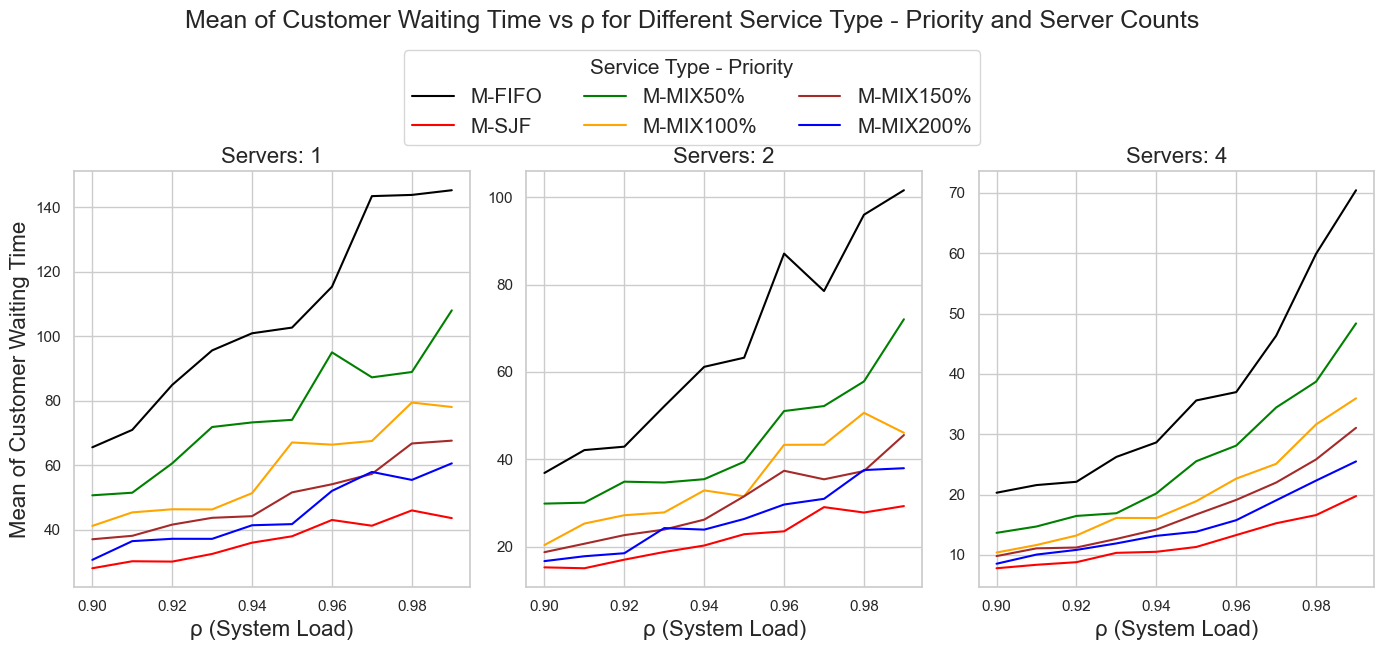

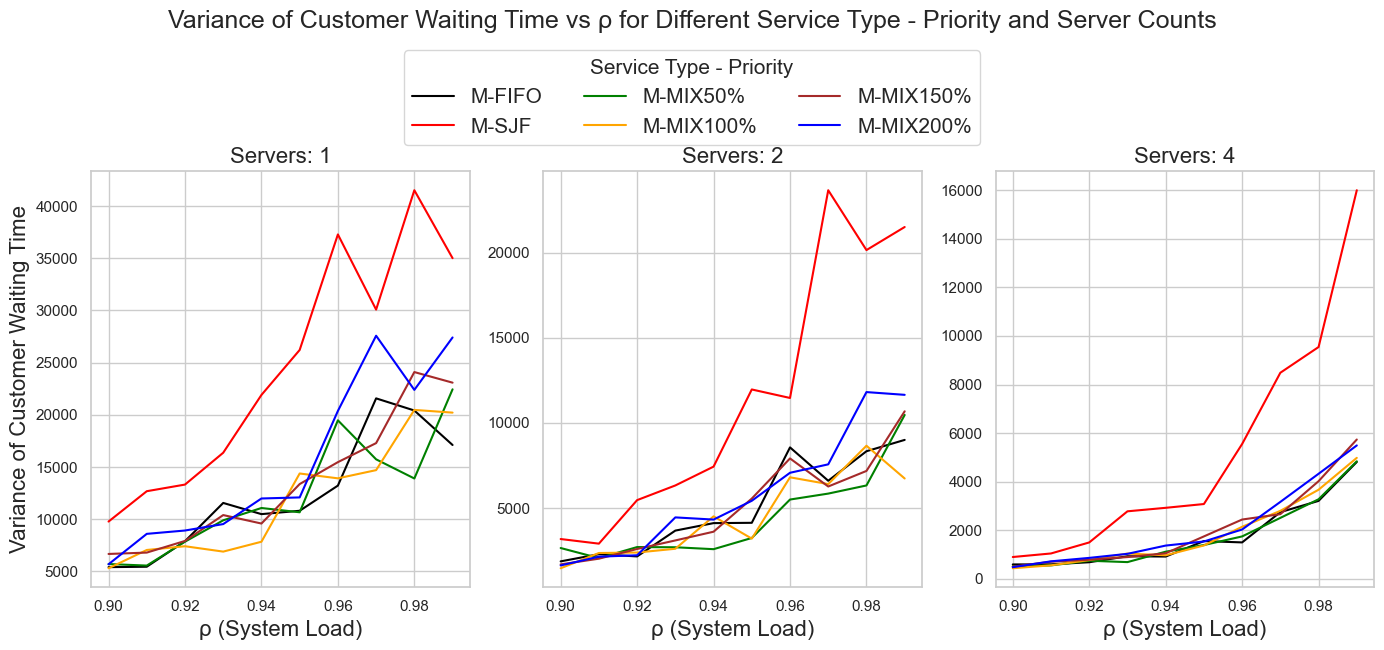

In [147]:
# Define colors corresponding to each service type
colors = {"FIFO": 'black', "SJF": 'red', "MIX50%": 'green', "MIX100%": "orange", "MIX150%": "brown", "MIX200%": "blue"}
vertical_axis_objects = ['Mean', 'Variance']
for vertical_axis_object in vertical_axis_objects:
    fig, axes = plt.subplots(1, 3, figsize=(14,6))

    # Create a handle list for legends
    handles_list = []

    # Plot the subplot for mean waiting time
    for i, servers in enumerate(n_values):
        ax = axes[i]
        
        for service_type in service_types:
            for priority in priorities:
                # Filter data for specific conditions
                mask = (df_applymix_waiting_times_results['Servers'] == servers) & \
                    (df_applymix_waiting_times_results['ServiceType'] == service_type) & \
                    (df_applymix_waiting_times_results['Priority'] == priority)
                subset = df_applymix_waiting_times_results[mask]
                
                # Plot the line graph of rho vs. mean waiting time
                handle, = ax.plot(subset['Rho'], subset[vertical_axis_object],
                                label=f'{service_type}-{priority}',
                                color=colors[priority])
                if i == 0:  # Add legend handles only in the first subplot
                    handles_list.append(handle)
        
        ax.set_title(f'Servers: {servers}', fontsize=16)
        ax.set_xlabel('ρ (System Load)', fontsize=16)
        if i == 0:
            ax.set_ylabel(vertical_axis_object+' of Customer Waiting Time', fontsize=16)
       

    # Add legend
    # Adjust bbox_to_anchor parameter when calling fig.legend
    fig.legend(handles=handles_list, loc='upper center', bbox_to_anchor=(0.5, 1.03),
            ncol=3, title='Service Type - Priority', title_fontsize=15, fontsize=15)

    # Adjust y parameter when calling fig.suptitle
    fig.suptitle(f'{vertical_axis_object} of Customer Waiting Time vs ρ for Different Service Type - Priority and Server Counts', fontsize=18, y=1.08)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
